<a href="https://colab.research.google.com/github/104H/dyadicdecisionmaking/blob/2ifc-random-dots/dataanalysis/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Run the following in the order stated below before this script**


1.   post_experiment for every experiment_pair. Ideally this was done already after every experiment for first level checks.
2.   fit_hddm (to have the parameter estimate of each subject for various conditions)



In [49]:
!pip install scipy==1.7.1

     |████████████████████████████████| 28.5 MB 1.8 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [1]:
import glob
import matplotlib.pyplot as plt
from math import sqrt
import numpy as np
import os
import pandas as pd
import scipy
import seaborn as sns
from scipy.special import erfcinv
sns.set_palette("Set2", desat=0.5)

**Part A: Is there a choice history bias in dyadic trials?**


Objectives: Test the hypothesis of choice history bias from dyadic interaction and characterise the nature of the bias.

Assumes: Choice history bias after own trials

Answers the questions:
1.   Is there a history bias if the previous trial is done by the partner?



    
    



In [3]:
#calculates dprime given dataframe of a subject's response
#filter for na when calculating p(repeat)

def dprime(df):
    """
    left (-1): signal present
    right (1) : signal absent
    """
    d = 0
    c = 0
    
    #calculate hit rate,HR and false alarm rate, FA
    signal = df[df['direction'] == -1].shape[0]
    nosignal = df[df['direction'] == 1].shape[0]

    hits = df[(df['direction'] == -1) & (df['response'] == -1)].shape[0]
    falsealarms = df[(df['direction'] == 1) & (df['response'] == -1)].shape[0]
    #print(signal,hits, nosignal,falsealarms)
    try:
        hit_rate = hits/signal
        fa_rate = falsealarms/nosignal

        if not (0 <= hit_rate <= 1 and 0 <= fa_rate <= 1):
            print("Hit Rate and/or False Alarm Rate out of range")

        if hit_rate > 0:
            hit_rate = min(hit_rate, 1 - 0.5/signal)
        else:
            hit_rate = 0.5/signal

        if fa_rate < 1:
            fa_rate = max(fa_rate, 0.5/nosignal)
        else:
            fa_rate = 1 - 0.5/nosignal

        zHit = -sqrt(2) * erfcinv(2 * hit_rate)
        zFA = -sqrt(2) * erfcinv(2 * fa_rate)

        d = zHit - zFA
        c = - 0.5 * (zHit + zFA)
    except Exception as e:
        print("Couldnt determine dprime and criterion. {}".format(e))
        
     
    return d,c

In [4]:
"""
Prepare for running
Combine data of all pairs if not done already
NOTE: If the combined file doesnt already exist it indicates that fit_HDDM wasnt done. Do that first. 
"""
datasrc = "drive/MyDrive/DDM_SP_2021-22/data/coded"
datafile = "all_trials_data.csv"

#if the concatenated data from each experimnetal run exists, use that, else create the concatenated data first
data_loc = os.path.join(datasrc,datafile)
if os.path.exists(data_loc):
    trials_df = pd.read_csv(data_loc)
    print("Concatenated datafile with full experiment data found and loaded")
else:
    files = glob.glob(os.path.join(datasrc,'pair*.csv'))
    mydata = pd.concat([pd.read_csv(f) for f in files ])
    mydata.to_csv(data_loc,index=False,header=True)
    print("Concatenated datafile with full experiment data at --> {}".format(data_loc))
    trials_df = pd.read_csv(data_loc)
    

prev_trials_window = 1 #shouldnt be more the parameter value in the post_experiment script

Concatenated datafile with full experiment data found and loaded


In [5]:
subjects = trials_df['subj_idx'].unique()
print(subjects)

['280933_1' '280933_2' '659640_1' '659640_2' '725232_1' '725232_2'
 '754128_1' '754128_2' '812810_1' '812810_2' '897304_2' '897304_1'
 '900778_1' '900778_2' '958733_2' '958733_1']


In [6]:
individual_data = []
for sid in subjects:
    tmpdict = {}
    tmpdict['subj_idx'] = sid
    tmpdf = trials_df[trials_df['subj_idx'] == sid]
    tmpdict['dprime'], tmpdict['criterion'] = dprime(tmpdf[['direction','response']])
    tmpdict['accuracy'] = tmpdf['correct'].mean()
    tmpdict['rt'] = tmpdf['rt'].median()
    tmpdict['bias'] = tmpdf['response'].mean()
    for n in range(1,prev_trials_window + 1):
        prefix = 'l' + str(n) + '_' #prefix for the column name
        col_stim = prefix + 'stim'
        t = tmpdf[~tmpdf[col_stim].isna()] #filter out rows where stim is NaN
        tmpdict[prefix + 'pr'] = t[prefix + 'repeat'].mean()
        own = t[prefix + 'subject'] == sid
        tmpdict[prefix + 'pr_own'] = t.loc[own,prefix + 'repeat'].mean()
        tmpdict[prefix + 'pr_dyad'] = t.loc[~own,prefix + 'repeat'].mean()
        
        fastRTs = t['rt'] < tmpdict['rt']
        slowRTs = t['rt'] > tmpdict['rt']
        
        tmpdict[prefix + 'pr_fastRT']= np.NaN
        tmpdict[prefix + 'pr_fastRT_own']= np.NaN
        tmpdict[prefix + 'pr_fastRT_dyad']= np.NaN
        tmpdict[prefix + 'pr_slowRT']= np.NaN
        tmpdict[prefix + 'pr_slowRT_own']= np.NaN
        tmpdict[prefix + 'pr_slowRT_dyad']= np.NaN
        
        if not fastRTs.empty:
            tmpdict[prefix + 'pr_fastRT']= t.loc[fastRTs,prefix + 'repeat'].mean()
            m1 = (t[prefix + 'subject'] == sid) & (t['rt'] < tmpdict['rt'])
            m2 = (t[prefix + 'subject'] != sid) & (t['rt'] < tmpdict['rt'])
            if not m1.empty:
                tmpdict[prefix + 'pr_fastRT_own']= t.loc[m1,prefix + 'repeat'].mean()
            if not m2.empty:
                tmpdict[prefix + 'pr_fastRT_dyad']= t.loc[m2,prefix + 'repeat'].mean()
        
        if not slowRTs.empty:
            tmpdict[prefix + 'pr_slowRT']= t.loc[slowRTs,prefix + 'repeat'].mean()
            m1 = (t[prefix + 'subject'] == sid) & (t['rt'] > tmpdict['rt'])
            m2 = (t[prefix + 'subject'] != sid) & (t['rt'] > tmpdict['rt'])
        if not m1.empty:
            tmpdict[prefix + 'pr_slowRT_own']= t.loc[m1,prefix + 'repeat'].mean()
        if not m2.empty:
            tmpdict[prefix + 'pr_slowRT_dyad']= t.loc[m2,prefix + 'repeat'].mean()
        
        
    individual_data.append(tmpdict)

individual_df = pd.DataFrame(individual_data)
display(individual_df)

,subj_idx,dprime,criterion,accuracy,rt,bias,l1_pr,l1_pr_own,l1_pr_dyad,l1_pr_fastRT,l1_pr_fastRT_own,l1_pr_fastRT_dyad,l1_pr_slowRT,l1_pr_slowRT_own,l1_pr_slowRT_dyad
0,280933_1,1.153914,0.146230,0.713402,1.078531,0.076289,0.459459,0.456067,0.462810,0.413223,0.396947,0.432432,0.504202,0.523364,0.488550
1,280933_2,2.396819,-0.488261,0.852362,0.913726,-0.153543,0.508911,0.469697,0.551867,0.498024,0.476562,0.520000,0.519841,0.463235,0.586207
2,659640_1,2.270160,-0.048344,0.871456,0.811110,-0.013233,0.455238,0.446043,0.465587,0.452471,0.500000,0.404580,0.459770,0.400000,0.534483
3,659640_2,1.174778,-0.041515,0.721627,0.726120,-0.036403,0.555315,0.625571,0.491736,0.549356,0.623853,0.483871,0.559471,0.623853,0.500000
4,725232_1,4.099362,-0.551058,0.964623,0.644632,-0.075472,0.528436,0.520000,0.538071,0.509434,0.523810,0.488372,0.547619,0.515152,0.576577
5,725232_2,0.019072,0.077703,0.504043,0.679856,0.061995,0.384824,0.344828,0.420513,0.362162,0.305556,0.398230,0.409836,0.376238,0.451220
6,754128_1,3.103126,0.202819,0.936000,0.438246,0.056000,0.465726,0.465306,0.466135,0.440000,0.406250,0.475410,0.491870,0.529915,0.457364
7,754128_2,1.196207,-0.372022,0.711968,0.488841,-0.245436,0.489754,0.563559,0.420635,0.522449,0.666667,0.384000,0.454545,0.456897,0.452381
8,812810_1,1.888245,0.023299,0.827083,0.674502,-0.020833,0.382664,0.391304,0.374486,0.292887,0.318519,0.259615,0.474359,0.494737,0.460432
9,812810_2,2.140807,-0.115217,0.854932,0.714718,-0.017408,0.403883,0.365672,0.445344,0.333333,0.355705,0.302752,0.472656,0.378151,0.554745


Mean Accuracy: 77.38%
Std Accuracy : 12.84%



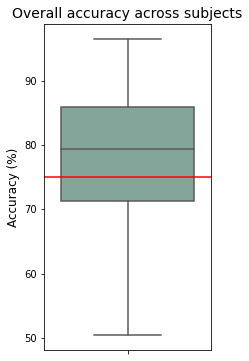

In [7]:
"""
Check the accuracy the set of subjects
"""
print("Mean Accuracy: {:5.2%}".format(individual_df['accuracy'].mean()))
print("Std Accuracy : {:5.2%}\n".format(individual_df['accuracy'].std()))
fig, ax = plt.subplots(figsize=(3,6))
sns.boxplot(y=individual_df['accuracy']*100,ax=ax)
ax.axhline(75,color='r')
ax.set_title("Overall accuracy across subjects",fontsize=14)
ax.set_ylabel("Accuracy (%)",fontsize=12)
plt.show()


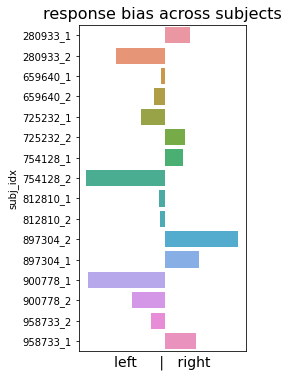

In [75]:
#Is there a response bias?
# To test: Is response bias and acccuracy correlated?
fig, ax = plt.subplots(figsize=(3,6))
sns.barplot(data=individual_df,x='bias',y='subj_idx',ax=ax)
ax.set_xticks([])
ax.set_xlabel("left     |   right",fontsize=14)
ax.set_title("response bias across subjects",fontsize=16)
plt.show()


In [8]:
"""
Plots barplot and boxplot of features in adjacent columns
plot_types: The features on which plots are to be made n=len(plot_types)
plot_df: dataframe sorted by a key feature 
"""
def do_nx2_plots(plot_types,labels,suptitle,plot_df):
    fig, ax = plt.subplots(len(plot_types),2,figsize=(10,6))
    for idx,p in enumerate(plot_types):
        sns.barplot(data=plot_df,x=p,y='subj_idx',ax=ax[idx][0])
        ax[idx][0].axvline(plot_df[p].mean(), color='red',linestyle='--')
        sns.boxplot(data=plot_df,x=p,ax=ax[idx][1])
        for i in range(2):
            ax[idx][i].set_xlim(0,1)
            ax[idx][i].axvline(0.5,color='black')
            ax[idx][i].set_xlabel(labels[p],fontsize=14)

    plt.suptitle(suptitle,y=1.01,fontsize=16)
    plt.tight_layout()
    plt.show()
    
    return  

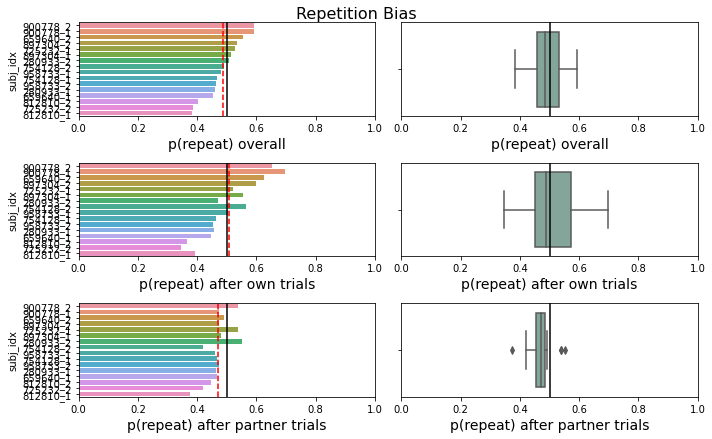

In [9]:
#repetition bias for all subjects
plots = ['l1_pr','l1_pr_own','l1_pr_dyad']
plot_labels = {
    'l1_pr': "p(repeat) overall",
    'l1_pr_own': "p(repeat) after own trials",
    'l1_pr_dyad': "p(repeat) after partner trials"
    
}

tmpdf = individual_df.sort_values(by='l1_pr', ascending=False)

do_nx2_plots(plots,plot_labels,"Repetition Bias",tmpdf)

**H0: There is no repetition bias after dyadic trials i.e. the p(repeat) after dyadic is 0.5**

In [56]:
pr_diff_frm_5 = individual_df['l1_pr_dyad'] - 0.5
pr_diff_frm_5.mean()

-0.029006829051898532

In [57]:
i=0
d = []
while i < 5000:
    df = pr_diff_frm_5.sample(n=pr_diff_frm_5.shape[0],replace=True)
    d.append(df.mean())      
    i += 1

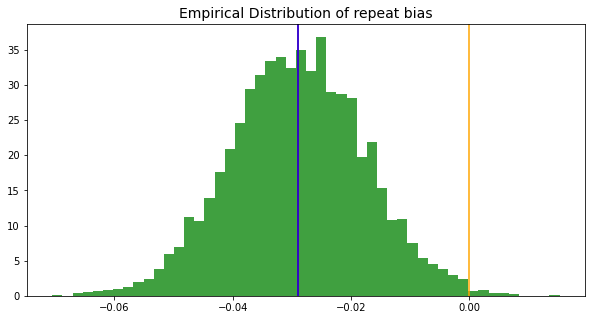

In [58]:
fig, ax = plt.subplots(figsize=(10,5))
n, bins, patches = plt.hist(d, 50, density=True, facecolor='g', alpha=0.75)
plt.axvline(np.mean(d),color='red')
plt.axvline(pr_diff_frm_5.mean(),color='blue')
plt.axvline(0,color='orange')
plt.title("Empirical Distribution of repeat bias",fontsize=14)
plt.show()

In [59]:
ci = scipy.stats.bootstrap((pr_diff_frm_5.to_numpy(),), np.mean, confidence_level=0.95)
print(ci.confidence_interval)

ConfidenceInterval(low=-0.05131100245485946, high=-0.00754644691908978)


**H0: For any subject there is no difference in the p(repeat) after own trial and after partner trial**

In [10]:
pr_diff = individual_df['l1_pr_own'] - individual_df['l1_pr_dyad']

In [11]:
pr_diff.mean()

0.03593888837646833

In [12]:
i=0
d1 = []
while i < 5000:
    df = pr_diff.sample(n=pr_diff.shape[0],replace=True)
    d1.append(df.mean())      
    i += 1

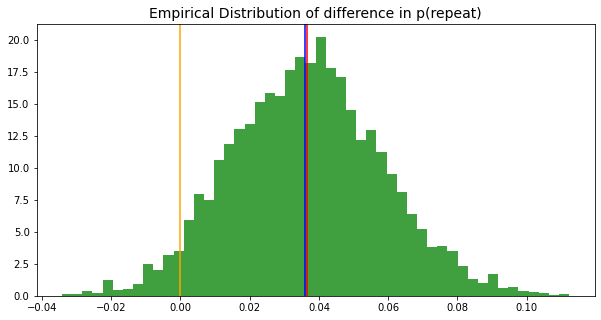

In [13]:
fig, ax = plt.subplots(figsize=(10,5))
n, bins, patches = plt.hist(d1, 50, density=True, facecolor='g', alpha=0.75)
plt.axvline(np.mean(d1),color='red')
plt.axvline(pr_diff.mean(),color='blue')
plt.axvline(0,color='orange')
plt.title("Empirical Distribution of difference in p(repeat)",fontsize=14)
plt.show()

In [44]:
ci = scipy.stats.bootstrap((pr_diff.to_numpy(),), np.mean, confidence_level=0.95)
print(ci.confidence_interval)

ConfidenceInterval(low=-0.003812590650760124, high=0.08256668906076972)


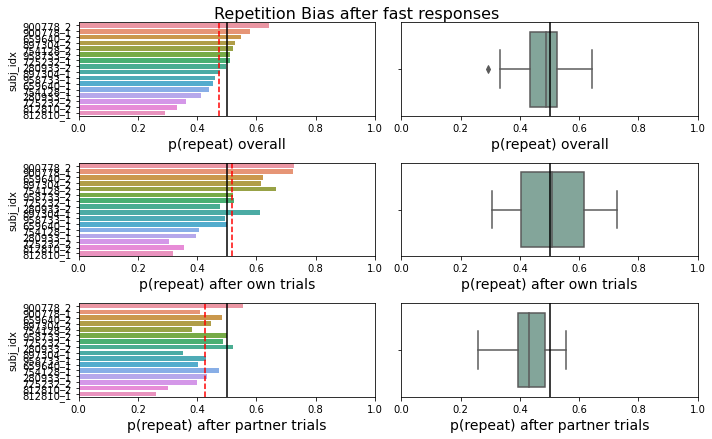

In [29]:
#repetition bias for fast resposnes for all subjects
plots = ['l1_pr_fastRT','l1_pr_fastRT_own','l1_pr_fastRT_dyad']
plot_labels = {
    'l1_pr_fastRT': "p(repeat) overall",
    'l1_pr_fastRT_own': "p(repeat) after own trials",
    'l1_pr_fastRT_dyad': "p(repeat) after partner trials"
    
}

tmpdf = individual_df.sort_values(by='l1_pr_fastRT', ascending=False)

do_nx2_plots(plots,plot_labels,"Repetition Bias after fast responses",tmpdf)

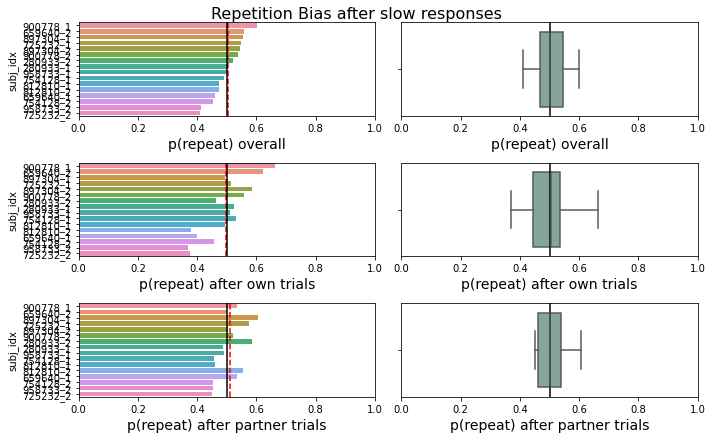

In [30]:
#repetition bias for slow resposnes for all subjects
plots = ['l1_pr_slowRT','l1_pr_slowRT_own','l1_pr_slowRT_dyad']
plot_labels = {
    'l1_pr_slowRT': "p(repeat) overall",
    'l1_pr_slowRT_own': "p(repeat) after own trials",
    'l1_pr_slowRT_dyad': "p(repeat) after partner trials"
    
}

tmpdf = individual_df.sort_values(by='l1_pr_slowRT', ascending=False)

do_nx2_plots(plots,plot_labels,"Repetition Bias after slow responses",tmpdf)

**H0: There is no difference in the p(repeat) after own trial between fast and slow responses**

In [33]:
fastslow_diff = individual_df['l1_pr_slowRT_own'] - individual_df['l1_pr_fastRT_own']
print(fastslow_diff.mean())

-0.0203730922252504


In [45]:
ci = scipy.stats.bootstrap((fastslow_diff.to_numpy(),), np.mean, confidence_level=0.95)
print(ci.confidence_interval)

ConfidenceInterval(low=-0.07220982084276807, high=0.034142210663045014)


**H0: There is no difference in the p(repeat) after partner's trial between fast and slow responses**

In [35]:
dyadicfastslow_diff = individual_df['l1_pr_slowRT_dyad'] - individual_df['l1_pr_fastRT_dyad']
print(dyadicfastslow_diff.mean())

0.08310694657239943


In [46]:
ci = scipy.stats.bootstrap((dyadicfastslow_diff.to_numpy(),), np.mean, confidence_level=0.95)
print(ci.confidence_interval)

ConfidenceInterval(low=0.044075003337163646, high=0.1321936342045167)


**H0: There is no difference in the p(repeat) after slow responses between dyadic and non-dyadic condition**

In [38]:
slow_diff = individual_df['l1_pr_slowRT_dyad'] - individual_df['l1_pr_slowRT_own']
slow_diff.mean()

0.014155933381045555

In [47]:
ci = scipy.stats.bootstrap((slow_diff.to_numpy(),), np.mean, confidence_level=0.95)
print(ci.confidence_interval)

ConfidenceInterval(low=-0.032657736674149083, high=0.058840229459745194)


**H0: There is no difference in the p(repeat) after fast responses between dyadic and non-dyadic condition**

In [40]:
fast_diff = individual_df['l1_pr_fastRT_dyad'] - individual_df['l1_pr_fastRT_own']
fast_diff.mean()

-0.08932410541660428

In [48]:
ci = scipy.stats.bootstrap((fast_diff.to_numpy(),), np.mean, confidence_level=0.95)
print(ci.confidence_interval)

ConfidenceInterval(low=-0.152708379256186, high=-0.032686765726912835)
